# Plot colony growth rate of Staph-Pseudomonas co-culture

To run this code install ipympl if you have not yet done so:

`conda install -c conda-forge ipympl`

In [1]:
#next two lines make sure that Matplotlib plots are shown properly in Jupyter Notebook
%matplotlib inline
%matplotlib widget
%config InlineBackend.figure_format = 'retina'

#main data analysis packages
import numpy as np
import seaborn as sns
import pandas as pd

#path handling
import pathlib

## Load data

In [2]:
#set path to output csv files
path_data_files = pathlib.Path() 

#set filenames
exp_name = "20230411"

#read data
csv_name = path_data_files / f"{exp_name}_all_data.csv"
df_all = pd.read_csv(csv_name, index_col=0)
df_all['colony_id'] = df_all['col_idx'].astype(int) #temp needed to fix bug in test data
df_all.head()

,label,area,centroid-0,centroid-1,axis_major_length,axis_minor_length,frame,pos,strain,condition,colony_id,col_idx,min_dist_PA_centroid
0,1,818,80.063570,1266.731051,35.040071,31.224062,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,0,0.0,180.846496
1,2,735,89.469388,1374.753741,43.489829,23.046311,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,1,1.0,224.546857
2,3,777,102.608752,1551.871300,34.768511,29.621879,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,2,2.0,105.645573
3,4,235,171.485106,1580.600000,23.340537,13.144388,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,3,3.0,88.521595
4,5,1282,224.416537,1096.703588,59.640729,28.771840,0,0,SA1,JE2RFP_gltTGFP_PAO1_TSB,4,4.0,130.954679


We now remove the PA data, as we only care about SA growth. 

We also removed untracked colonies. 

Finally we create a unique id for each colony by combining pos with colony_id

Then we plot number of colonies as function of time, to choose the final time point to analyze (before too many colonies merge)

In [3]:
df = df_all.loc[(~(df_all['strain']=='PA')) & (df_all['colony_id']>=0)]

df['poscol_id'] = df['PositionIdx'].map(str) + '-' + df['ChannelIdx'].map(str) + '-' + df['BacteriaLineage'].map(str)




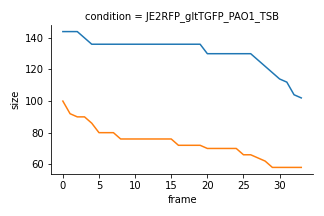

In [7]:
col_num_t = df.groupby(['strain','frame','condition'], as_index=False).size()
g = sns.FacetGrid(data=col_num_t, col='condition',hue='strain',aspect=1.5)
g.map_dataframe(sns.lineplot, x='frame', y='size')

Amove we start to see a lot of colony mergers after t=26, so let's calculate the growth rate between t=0 and t=26.

In [8]:
def derivative(y, frm_interval=1, log = False):
    if y.size > 2:
        y = np.log(y) if log else y
        x = np.arange(y.size) * frm_interval
        p = np.polyfit(x, y, 1) #simply 1st order polynomial fit / regression (numpy.polyfit)
        ddt = p[0] #slope of first order fit in python p[0]
    else: 
        ddt = np.nan 
    return ddt 

In [ ]:
mu = df.groupby('lin_id_str')['Spinelength'].rolling(3, min_periods=2, center=True).apply(derivative, kwargs={'frm_interval':frm_interval, 'log':True}).reset_index(0,drop=True)
df['mu'] = mu